In [ ]:
from mcmd.densities import Funnel, GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import torch

In [ ]:
# Seaborn setup 
sns.set_style('white')

In [ ]:
import torch

class Test:
    def __init__(self) -> None:
        self.x = 10
        
    def run(self, y):
        return (self.x + y).mean()

test = Test()

def f(x):
    return test.run(x)

df = torch.func.grad(f)

df(torch.tensor([2.0], requires_grad=True))

In [7]:
from mcmd.sampler import CMCD
from mcmd.score import ResNet
from mcmd.densities import GaussianMixture
from mcmd.anneal import GeometricAnnealing

import torch 
import torch.nn as nn 
from torch.distributions import MultivariateNormal


In [13]:

score_fn = ResNet(2, 38, 40, 8).cuda()
score_fn.reset_parameters()

initial_dist = MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).cuda(),
    covariance_matrix=(torch.eye(2) * 2 * 2).cuda(),
    validate_args=False
)

target = GaussianMixture()

anneal = GeometricAnnealing()

sampler = CMCD(initial_dist, target, anneal, score_fn, 8, 0.06).cuda()

optim = torch.optim.Adam(sampler.parameters(), lr=1e-3)

In [5]:
%timeit sampler.sample(500)

198 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:

import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-20, 20, 30)
y = np.linspace(-20, 20, 30)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32).cuda()

# %timeit sampler.drift(coords, 4).cpu().detach()
%timeit sampler.log_phi(coords, 6 / 8)



2.17 ms ± 39.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [47]:
Tensor = torch.Tensor
import einops


class GaussianMixture:
    mean_a = torch.tensor([3.0, 0.0]).cuda()
    mean_b = torch.tensor([-2.5, 0.0]).cuda()
    mean_c = torch.tensor([2.0, 3.0]).cuda()
    means = torch.stack((mean_a, mean_b, mean_c), dim=0)
    cov_a = torch.tensor([[0.7, 0.0], [0.0, 0.05]]).cuda()
    cov_b = torch.tensor([[0.7, 0.0], [0.0, 0.05]]).cuda()
    cov_c = torch.tensor([[1.0, 0.95], [0.95, 1.0]]).cuda()
    covs = torch.stack((cov_a, cov_b, cov_c), dim=0)
    log_weights = torch.tensor([1.0 / 3, 1.0 / 3.0, 1.0 / 3.0]).log().cuda()
    l: Tensor = torch.linalg.cholesky(covs)
    n = GaussianMixture.means.shape[-1]
    norm = -n / 2 * np.log(2 * np.pi) - torch.log(
            GaussianMixture.l.diagonal(dim1=-2, dim2=-1)
        ).sum(dim=1)

    def __init__(self) -> None:
        super().__init__()
        
    def util(self, x: Tensor):
        y = torch.linalg.solve_triangular(
            GaussianMixture.l,
            (x.unsqueeze(-2) - GaussianMixture.means).unsqueeze(-1),
            upper=False,
        ).squeeze(dim=-1)
        individual_log_pdfs = -1 / 2 * torch.einsum("...i,...i->...", y, y) + GaussianMixture.norm
        
        return normalizing_term

        

    def asymmetric_density(self, x: Tensor):
        y = torch.linalg.solve_triangular(
            GaussianMixture.l,
            (x.unsqueeze(-2) - GaussianMixture.means).unsqueeze(-1),
            upper=False,
        ).squeeze(dim=-1)
        individual_log_pdfs = -1 / 2 * torch.einsum("...i,...i->...", y, y) + GaussianMixture.norm
        
        mixture_weighted_pdfs = individual_log_pdfs + GaussianMixture.log_weights

        result = torch.logsumexp(mixture_weighted_pdfs, dim=-1)

        return result

    def log_density(self, x):
        logp1 = self.asymmetric_density(x) - np.log(2.0)
        logp2 = self.asymmetric_density(torch.flip(x, dims=[-1])) - np.log(2.0)

        if x.dim() > 1:
            return einops.reduce([logp1, logp2], "b w -> w", torch.logsumexp)

        if x.dim() == 1:
            return torch.logsumexp(torch.stack([logp1, logp2]), dim=0)

In [48]:
target = GaussianMixture()
%timeit target.util(coords)

TypeError: dot() got an unexpected keyword argument 'dim'

tensor(nan)


/home/brianlck/miniconda3/lib/python3.9/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/brianlck/miniconda3/lib/python3.9/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/tmp/ipykernel_3883/1416454746.py:18: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, mag)


IndexError: index 1 is out of bounds for axis 0 with size 1

/home/brianlck/miniconda3/lib/python3.9/site-packages/matplotlib/quiver.py:633: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/home/brianlck/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/brianlck/miniconda3/lib/python3.9/site-packages/matplotlib/transforms.py:2663: RuntimeWarning: divide by zero encountered in double_scalars
  y_scale = 1.0 / inh
/home/brianlck/miniconda3/lib/python3.9/site-packages/matplotlib/transforms.py:2665: RuntimeWarning: invalid value encountered in double_scalars
  [0.0    , y_scale, (-inb*y_scale)],
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should

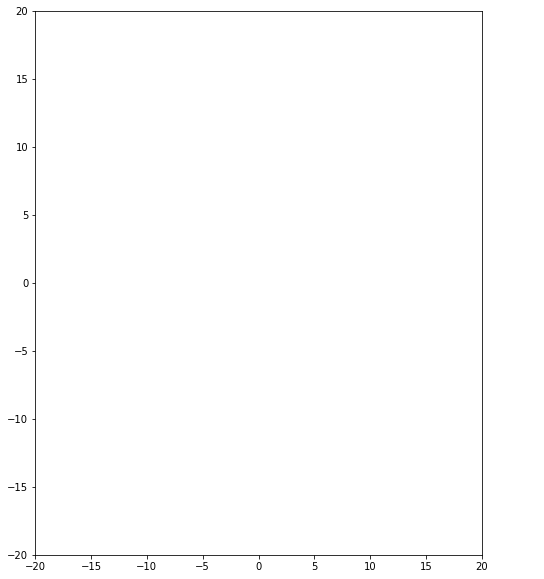

In [12]:

import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-20, 20, 30)
y = np.linspace(-20, 20, 30)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32).cuda()

gg = sampler.drift(coords, 4).cpu().detach()
mag = torch.norm(gg, dim=1).reshape(30, 30)

print(torch.norm(gg, dim=0).mean())
plt.figure(figsize=(10, 10))

plt.quiver(X, Y, gg[:, 0], gg[:, 1])
plt.contour(X, Y, mag)
plt.colorbar()



In [ ]:
score_fn.scale_factor

In [9]:
for i in range(10000):
    optim.zero_grad()
    samples = sampler.sample(100)
    loss = samples.loss
    assert loss != None
    # if i % 20 == 0:
    print(loss.item(), sampler.mult.item(), sampler.score_fn.scale.item())
    loss.backward()
    optim.step()
    

/home/brianlck/miniconda3/lib/python3.9/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


1.0472798996445476e+20 100.0 0.0
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan
nan nan nan


KeyboardInterrupt: 

In [ ]:
sampler.grid_t

In [ ]:
import torch.autograd.profiler as profiler

with profiler.profile(with_stack=True, profile_memory=True) as prof:
    samples = sampler.sample(10)

In [ ]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=100))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-50, 50, 10)
y = np.linspace(-50, 50, 10)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32).cuda()

score = score_fn(coords, 4).detach().cpu()
mag = torch.norm(score, dim=1).reshape(10, 10)

plt.quiver(X, Y, score[:, 0], score[:, 1])
plt.contour(X, Y, mag)
plt.colorbar()

In [ ]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32)

score = sampler.grad_log_phi(coords, 6 / 8).detach()
mag = torch.norm(score, dim=1).reshape(100, 100)

score = score / mag.reshape(-1, 1)


densities = target.log_density(coords).reshape(100, 100).exp()

plt.figure(figsize=(20, 20))
plt.quiver(X, Y, score[:, 0], score[:, 1])
plt.colorbar()

In [ ]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, dtype=torch.float32)

print(torch.exp(target.log_density(coords)).max())

score = torch.func.jacrev(lambda x: target.log_density(x).mean())(coords).detach()
mag = torch.norm(score, dim=1).reshape(100, 100)

densities = target.log_density(coords).reshape(100, 100).exp()

score = score / mag.reshape(-1, 1)

plt.figure(figsize=(20, 20))

plt.quiver(X, Y, score[:, 0], score[:, 1])
plt.contour(X, Y, densities)
plt.colorbar()

tensor(0.9893)


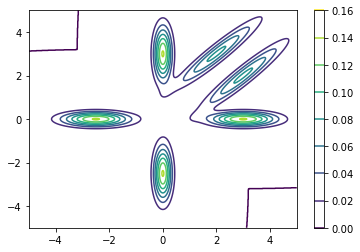

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)

X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T
coords = torch.tensor(coords, device='cuda')

density = GaussianMixture().log_density(coords).reshape(1000, 1000).T.exp().cpu()


dS = (x[1] - x[0]) * (y[1] - y[0])
cum = density.sum() * dS

print(cum)



plt.contour(X, Y, density)
plt.colorbar()

In [ ]:
score_fn(coords[:2], 1)

In [ ]:
score_fn(coords[:2], 2)